In [1]:
import tensorflow as tf
import pathlib
import re
import string
import collections
import numpy as np
from tqdm import tqdm

In [2]:
# Hyperparameters
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
EMBEDDING_DIM = 256
LSTM_UNITS = 256
VOCAB_SIZE = 5000
MAX_SEQ_LEN = 30
EPOCHS = 5
LEARNING_RATE = 3e-3
CHECKPOINT_PATH = "checkpoints/image_captioning"

In [3]:
# Step 1: Download and prepare Flickr8k dataset
def download_data():
    path = pathlib.Path('flickr8k')
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True
    )
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True
    )
    return path

In [4]:
# Step 2: Preprocess images with augmentation
def preprocess_image(img_path, augment=False):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SHAPE[:2])
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

        # Custom random rotation
        angle = tf.random.uniform([], -0.2, 0.2)  # Random angle in radians
        img = tfa_custom_rotate(img, angle)
    return img / 255.0

def tfa_custom_rotate(image, angle):
    # Compute the rotation matrix
    rotation_matrix = tf.convert_to_tensor([
        [tf.cos(angle), -tf.sin(angle), 0],
        [tf.sin(angle), tf.cos(angle), 0],
    ])
    # Flatten the matrix to [1 x 8] with additional zeros for affine transform
    flat_matrix = tf.reshape(rotation_matrix, [-1])
    flat_matrix = tf.concat([flat_matrix, tf.zeros([2])], axis=0)  # Add padding to make [1 x 8]

    # Apply the rotation
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    rotated_image = tf.raw_ops.ImageProjectiveTransformV2(
        images=image,
        transforms=tf.expand_dims(flat_matrix, axis=0),
        output_shape=tf.shape(image)[1:3],
        interpolation="BILINEAR"
    )
    return tf.squeeze(rotated_image, axis=0)  # Remove batch dimension

In [5]:
def preprocess_images(image_paths, augment=False):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(lambda img: preprocess_image(img, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
    return image_ds

In [6]:
# Step 3: Preprocess captions
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f"[{re.escape(string.punctuation)}]", "")
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text

In [7]:
def tokenize_captions(captions):
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_sequence_length=MAX_SEQ_LEN,
        standardize=standardize
    )
    vectorizer.adapt(captions)
    return vectorizer

In [8]:
# Step 4: Build the dataset
def build_dataset(img_paths, captions, vectorizer, batch_size, augment=False):
    caption_ds = tf.data.Dataset.from_tensor_slices(captions).map(vectorizer)
    image_ds = preprocess_images(img_paths, augment=augment)
    dataset = tf.data.Dataset.zip((image_ds, caption_ds))
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
# Step 5: Create Encoder-Decoder Model
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.feature_extractor = tf.keras.applications.MobileNetV3Small(
            input_shape=IMG_SHAPE, include_top=False, pooling="avg"
        )
        self.dense = tf.keras.layers.Dense(embedding_dim, activation="relu")

    def call(self, images):
        features = self.feature_extractor(images)
        # print(f"Encoder Output Shape: {features.shape}")
        return self.dense(features)

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.2)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, captions, features, hidden_state):
        embeddings = self.embedding(captions)
        # Only pass the features during the first time step
        embeddings = tf.concat([tf.expand_dims(features, 1), embeddings], axis=1)
        lstm_output, *hidden_state = self.lstm(embeddings, initial_state=hidden_state)
        logits = self.dense(lstm_output[:, -1, :])  # Predict for the last token
        return logits, hidden_state

In [11]:
def build_model(vocab_size, embedding_dim, lstm_units):
    encoder = Encoder(embedding_dim)
    decoder = Decoder(embedding_dim, lstm_units, vocab_size)
    return encoder, decoder

In [12]:
@tf.function
def train_step(encoder, decoder, optimizer, loss_fn, batch):
    images, captions = batch
    loss = 0
    with tf.GradientTape() as tape:
        features = encoder(images)

        # Dynamically adjust the hidden state to match the current batch size
        current_batch_size = tf.shape(features)[0]
        hidden_state = [tf.zeros((current_batch_size, LSTM_UNITS)) for _ in range(2)]

        for i in range(1, captions.shape[1]):
            dec_input = captions[:, :i]
            predictions, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(captions[:, i], predictions)  # Align logits with the next token
    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss / captions.shape[1]

In [13]:
def train_model(encoder, decoder, train_dataset, epochs, checkpoint_path):
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=3)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        for batch in tqdm(train_dataset):
            total_loss += train_step(encoder, decoder, optimizer, loss_fn, batch)
        print(f"Loss: {total_loss / len(train_dataset)}")
        manager.save()

In [14]:
# Main execution
path = download_data()
captions_file = path / "Flickr8k.token.txt"
captions = [line.split("\t") for line in captions_file.read_text().splitlines()]
captions_dict = collections.defaultdict(list)
for img_path, caption in captions:
    captions_dict[img_path.split("#")[0]].append(caption)

# Convert image paths to strings
image_paths = [str(path) for path in (path / "Flicker8k_Dataset").glob("*.jpg")]
captions_list = [" ".join(captions_dict[path.split('/')[-1]]) for path in image_paths]

vectorizer = tokenize_captions(captions_list)

1115419746/1115419746 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
2340801/2340801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Sanity checks
print(f"Number of images: {len(image_paths)}")
print(f"Number of captions: {len(captions_list)}")
print(f"Sample caption after vectorization: {vectorizer(captions_list[:1]).numpy()}")

Number of images: 8091
Number of captions: 8091
Sample caption after vectorization: [[  9   4  63  87   3   4  94  14  63  18  35   3  29 338 133  94  14  63
   35   3   2 133  94  14  63  87   3   4  25  13]]


In [16]:
# from nltk.translate.bleu_score import sentence_bleu

# def compute_bleu_score(reference_captions, generated_caption):
#     """
#     Computes BLEU score for a single generated caption.
#     Args:
#         reference_captions (list): List of reference captions for the image.
#         generated_caption (str): The caption generated by the model.
#     Returns:
#         float: BLEU score for the generated caption.
#     """
#     references = [ref.split() for ref in reference_captions]
#     hypothesis = generated_caption.split()
#     return sentence_bleu(references, hypothesis)

In [17]:
# def evaluate_on_validation_set(encoder, decoder, vectorizer, val_images, val_captions):
#     bleu_scores = []
    
#     for img_path, reference_captions in zip(val_images, val_captions):
#         # Generate caption
#         generated_caption = generate_caption(encoder, decoder, vectorizer, img_path)
        
#         # Compute BLEU score
#         bleu = compute_bleu_score(reference_captions, generated_caption)
#         bleu_scores.append(bleu)
        
#         # # Optional: Print some predictions for analysis
#         # print(f"Image: {img_path}")
#         # print(f"Generated Caption: {generated_caption}")
#         # print(f"BLEU Score: {bleu}\n")
    
#     # Average BLEU score
#     avg_bleu = sum(bleu_scores) / len(bleu_scores)
#     print(f"Average BLEU Score on Validation Set: {avg_bleu}")
#     return avg_bleu


In [18]:
train_split = int(0.8 * len(image_paths))
# val_split = int(0.9 * len(image_paths))

train_images = image_paths[:train_split]
train_captions = captions_list[:train_split]
# val_images = image_paths[train_split:val_split]
# val_captions = captions_list[train_split:val_split]
test_images = image_paths[train_split:]
test_captions = captions_list[train_split:]


# train_ds = build_dataset(train_images, train_captions, vectorizer, BATCH_SIZE, augment=True)

# encoder, decoder = build_model(VOCAB_SIZE, EMBEDDING_DIM, LSTM_UNITS)
# train_model(encoder, decoder, train_ds, EPOCHS, CHECKPOINT_PATH)

In [19]:
# # Force variable initialization for encoder and decoder
# dummy_image = tf.random.uniform((1, *IMG_SHAPE))  # Dummy image input
# dummy_features = encoder(dummy_image)  # Forward pass through encoder

# dummy_caption = tf.random.uniform((1, MAX_SEQ_LEN), maxval=VOCAB_SIZE, dtype=tf.int32)  # Dummy caption input
# dummy_hidden_state = [tf.zeros((1, LSTM_UNITS)) for _ in range(2)]  # Dummy hidden state
# _ = decoder(dummy_caption, dummy_features, dummy_hidden_state)  # Forward pass through decoder

# # Ensure optimizer variables are initialized
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [20]:
@tf.function
def train_step(encoder, decoder, optimizer, loss_fn, batch):
    images, captions = batch
    loss = 0
    with tf.GradientTape() as tape:
        # Forward pass through encoder
        features = encoder(images)
        hidden_state = [tf.zeros((tf.shape(features)[0], LSTM_UNITS)) for _ in range(2)]
        
        # Generate predictions and compute loss
        for i in range(1, captions.shape[1]):
            dec_input = captions[:, :i]
            predictions, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(captions[:, i], predictions)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss / captions.shape[1]

In [21]:
train_ds = build_dataset(train_images, train_captions, vectorizer, BATCH_SIZE, augment=True)

encoder, decoder = build_model(VOCAB_SIZE, EMBEDDING_DIM, LSTM_UNITS)
train_model(encoder, decoder, train_ds, EPOCHS, CHECKPOINT_PATH)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


100%|██████████| 102/102 [01:48<00:00,  1.07s/it]


Loss: 5.339678764343262
Epoch 2/5


100%|██████████| 102/102 [00:41<00:00,  2.43it/s]


Loss: 4.398123741149902
Epoch 3/5


100%|██████████| 102/102 [00:41<00:00,  2.43it/s]


Loss: 3.972198247909546
Epoch 4/5


100%|██████████| 102/102 [00:42<00:00,  2.43it/s]


Loss: 3.724562406539917
Epoch 5/5


100%|██████████| 102/102 [00:42<00:00,  2.38it/s]


Loss: 3.508723735809326


Predicted token ID: 2, Word: a
Predicted token ID: 16, Word: black
Predicted token ID: 8, Word: dog
Predicted token ID: 6, Word: is
Predicted token ID: 46, Word: jumping
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 3, Word: in
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a
Predicted token ID: 2, Word: a


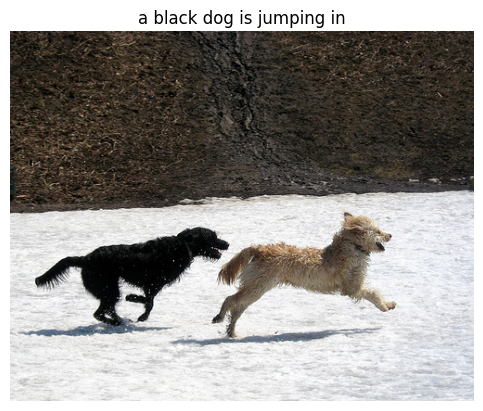

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess a single image
def preprocess_image_for_test(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SHAPE[:2])  # Resize to match the training image shape
    img = img / 255.0  # Normalize to [0, 1]
    return tf.expand_dims(img, axis=0)  # Add batch dimension

def generate_caption(encoder, decoder, vectorizer, img_path, temperature=0.2):
    # Preprocess the image
    preprocessed_img = preprocess_image_for_test(img_path)

    # Extract features using the encoder
    features = encoder(preprocessed_img)

    # Initialize the decoder's hidden state
    hidden_state = [tf.zeros((1, LSTM_UNITS)) for _ in range(2)]

    # Correctly initialize the start token
    start_token_id = vectorizer.get_vocabulary().index("[START]")
    start_token = tf.expand_dims([start_token_id], axis=0)  # Add batch dimension

    generated_caption = []
    used_tokens = set()  # Track tokens to avoid repetition

    for _ in range(MAX_SEQ_LEN):
        predictions, hidden_state = decoder(start_token, features, hidden_state)

        # Apply temperature scaling
        predictions = predictions / temperature
        probabilities = tf.nn.softmax(predictions, axis=-1).numpy()

        # Sample from the distribution
        predicted_id = np.random.choice(len(probabilities[0]), p=probabilities[0])

        # Convert token ID back to text
        predicted_word = vectorizer.get_vocabulary()[predicted_id]

        # Debugging Line: Print the predicted token ID and corresponding word
        print(f"Predicted token ID: {predicted_id}, Word: {predicted_word}")

        # Stop if the end token is predicted
        if predicted_word == "[END]":
            break

        # Avoid repetition by skipping already-used words
        if predicted_word in used_tokens:
            continue
        used_tokens.add(predicted_word)

        generated_caption.append(predicted_word)

        # Update the input for the next step
        start_token = tf.expand_dims([predicted_id], axis=0)

    return " ".join(generated_caption)

# Function to display the image and caption
def display_image_with_caption(img_path, caption):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage

# img_path = '/kaggle/working/flickr8k/Flicker8k_Dataset/2219959872_988e6d498e.jpg'
img_path = "/kaggle/working/flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg"  # Replace with your test image path
caption = generate_caption(encoder, decoder, vectorizer, img_path)
display_image_with_caption(img_path, caption)

In [23]:
# # Training loop
# best_bleu = 0.0
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# for epoch in range(EPOCHS):
#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     total_loss = 0

#     # Training loop
#     for batch in train_ds:
#         total_loss += train_step(encoder, decoder, optimizer, loss_fn, batch)
    
#     print(f"Training Loss: {total_loss / len(train_ds)}")
    
#     # Evaluate on validation set
#     val_bleu = evaluate_on_validation_set(encoder, decoder, vectorizer, val_images, val_captions)
    
#     # Save model if validation BLEU improves
#     if val_bleu > best_bleu:
#         best_bleu = val_bleu
#         checkpoint.save(file_prefix=CHECKPOINT_PATH)
#         print(f"New best BLEU score: {best_bleu}. Model saved.")

In [26]:
# Save the encoder and decoder models
encoder.save('/kaggle/working/encoder_model')
decoder.save('/kaggle/working/decoder_model')
print("Models saved successfully!")

AttributeError: 'Encoder' object has no attribute 'save'

In [31]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(reference_captions, generated_caption):
    """
    Compute BLEU score for a single generated caption.
    Args:
        reference_captions (list): List of reference captions for the image.
        generated_caption (str): Caption generated by the model.
    Returns:
        float: BLEU score.
    """
    references = [ref.split() for ref in reference_captions]  # Tokenize reference captions
    hypothesis = generated_caption.split()  # Tokenize generated caption
    return sentence_bleu(references, hypothesis)


In [36]:
def evaluate_bleu(encoder, decoder, vectorizer, test_images, test_captions):
    bleu_scores = []

    for img_path, reference_captions in zip(test_images, test_captions):
        # Generate a caption for the image
        generated_caption = generate_caption(encoder, decoder, vectorizer, img_path)
        
        # Compute BLEU score
        bleu = compute_bleu(reference_captions, generated_caption)
        bleu_scores.append(bleu)
        
        # Print results for analysis
        # print(f"Image: {img_path}")
        # print(f"Reference Captions: {reference_captions}")
        # print(f"Generated Caption: {generated_caption}")
        # print(f"BLEU Score: {bleu}\n")

    # Average BLEU score
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score on Test Set: {avg_bleu}")
    return avg_bleu
    

In [37]:
# Example: Evaluating BLEU on the test set

average_bleu = evaluate_bleu(encoder, decoder, vectorizer, test_images, test_captions)
print(f"Average BLEU Score: {average_bleu}")


Average BLEU Score on Test Set: 0.6552575111476422
Average BLEU Score: 0.6552575111476422
